## Feature Selection

We will adopt two filted feature selection methods based on correlation and entropy (mutual information) and wrapper to explore the most important features.

In [148]:
# This tells matplotlib not to try opening a new window for each plot.
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import time
import random
import scipy.io as sio

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.pyplot import figure


# sklearn
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate


# internal modules
from base_regressor_plot import BaseRegressorPlot
from configurations import args
from data_loader_fs import DataLoaderFS
from elastic_net_regressor import ElasticNetRegressor
from decision_tree_regressor import DecisionTreeRegressor
from lasso_regressor import LassoRegressor
from linear_regressor import LinearRegressor
from random_forest_regressor import RandomForestRegressor
from ridge_regressor import RidgeRegressor
from neuralnetwork import create_nn_regressor


### 1. Filter method
-  Based on correlation with SalePrice, we pick a threshold of 0.5
-  Based on mutual information, we pick a thredshold of 0.15

    Below are the detailed steps:

1.1 Corrlation based feature selection 

In [149]:
# download data file if it is not ready
data_file = Path(args.data_path)
if data_file.is_file():
    print("Datafile is already loaded.")
else:
    !curl -L "https://drive.google.com/uc?export=download&id=1ortEJfmlpt9-dbg5f6cTDt5nicswf5wT" > 'test.csv'
    !curl -L "https://drive.google.com/uc?export=download&id=1EG5jP5RDEIsNAMaF2m42KOyz-ZVjC8wS" > 'train.csv'
data_loader = DataLoaderFS(args)
df = data_loader.df

Datafile is already loaded.


In [150]:
# df_fs = data_loader.df

X_train_fs, X_test_fs, y_train_fs, y_test_fs = data_loader.get_raw_split_fs()
X_filter_fs = data_loader.data_prep(X_train_fs)


In [151]:
regressor_list=[LinearRegression(),
            Ridge(alpha=1.5),
            Lasso(alpha=0.1),
            ElasticNet(alpha=0.1, l1_ratio=0.5),
            DTR(max_depth=10),
            RFR()]

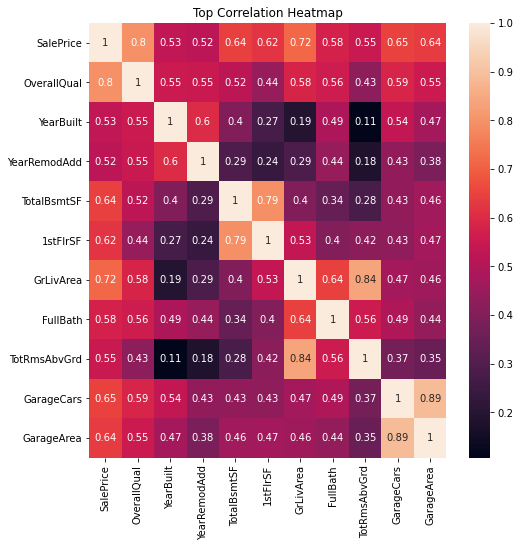

In [152]:
# get only the features with correlation above cutoff

def get_plot_heatmap_top(threshold=0.5):
    
    ''' 
    compute and plot the corr matrix with all top features 
    (correlation with saleprice above above thredshod)
    plot the correlation heatmap
    
    '''
    df_corr = y_train_fs.merge(
        X_train_fs, how="inner", left_index=True, right_index=True)

    corr_matrix = df_corr.corr()
    top_corr = corr_matrix[corr_matrix["SalePrice"] > threshold]
    top_corr = top_corr.loc[:, top_corr.index]

    fig = plt.figure(figsize=(8, 8))
    sns.heatmap(top_corr, annot=True)
    plt.title("Top Correlation Heatmap")

    return top_corr


top_corr = get_plot_heatmap_top()


1.2 Mutual Information based feature selection

In [153]:
#calculate mutual infomation and plot

def make_mi_scores(X, y,threshold=0.15):

    ''' convert all discrete features to int and calculate mutual information '''

    mi_scores = mutual_info_regression(X, y,  random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores[mi_scores>threshold]
    return mi_scores


def plot_mi_scores(scores):

    ''' plot the mutual information for all the selected features '''

    scores = scores.sort_values(ascending=True)
    scores = scores
    width = np.arange(len(scores))
    ticks = list(scores.index)
    figure(figsize=(8,6),dpi=100)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


/Users/jq279/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


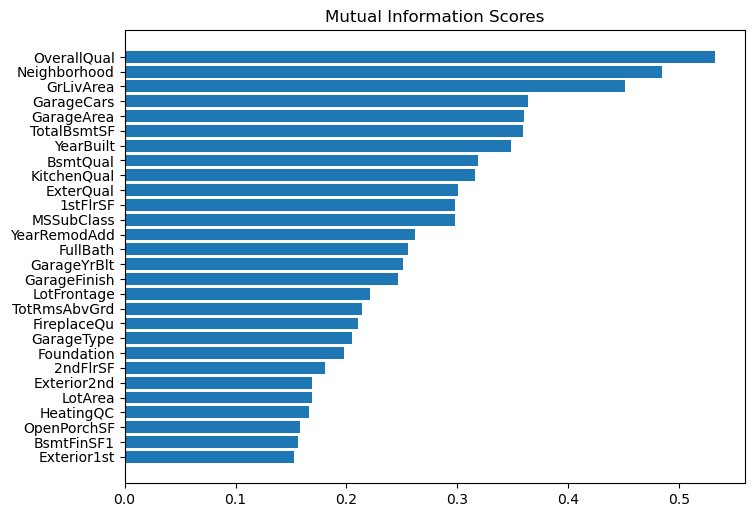

In [154]:
mi_scores = make_mi_scores(X_filter_fs, y_train_fs)
plot_mi_scores(mi_scores)

1.3 Merge to get the final filtered features

In [155]:
#create a union of the features with top correlation with Saleprice and the features above mutual information threshold

features_selected=data_loader.get_top_feature(top_corr, mi_scores, X_filter_fs)
X_train = data_loader.data_prep(X_train_fs[features_selected])
y_train = y_train_fs
X_test = data_loader.data_prep(X_test_fs[features_selected])
y_test = y_test_fs

1.4 Fit the new feature set to all the models and calculate the metric(RMSE)

In [156]:
# create a list of model will be used
regressor_list=[LinearRegression(),
            Ridge(alpha=1.5),
            Lasso(alpha=1,max_iter=5000),
            ElasticNet(alpha=2.0, l1_ratio=0.5, max_iter=300000),
            DTR(max_depth=10),
            RFR(max_depth=10)
            ]

In [157]:
def analyze_regression(regressor):
    '''
    run models and calculate the RMSE/plot the test result
    '''

    if regressor.__dict__.get("base_estimator")!=None:
        if str(regressor.__dict__.get("base_estimator"))=="DecisionTreeRegressor()":
            regressor.fit(X_train,np.ravel(np.array(y_train)))
    else: regressor.fit(X_train, y_train)

    RMSE=mean_squared_error(y_test, regressor.predict(X_test),squared=False)

    return regressor, RMSE, regressor.predict(X_test)


In [158]:
dict_results={}
k=0
for regressor in regressor_list:
    model_used, RMSE_result, y_predicted =analyze_regression(regressor)
    dict_results[k]={"model":model_used,"RMSE":RMSE_result, "y_predicted":y_predicted}
    k+=1

In [159]:
model_name=["LinearRegression",
            "Ridge",
            "Lasso",
            "ElasticNet",
            "DecisionTreeRegressor",
            "RandomForestRegressor"
            ]

Text(0.5, 0.98, 'Model Test versus Predicted -- Filtered Method')

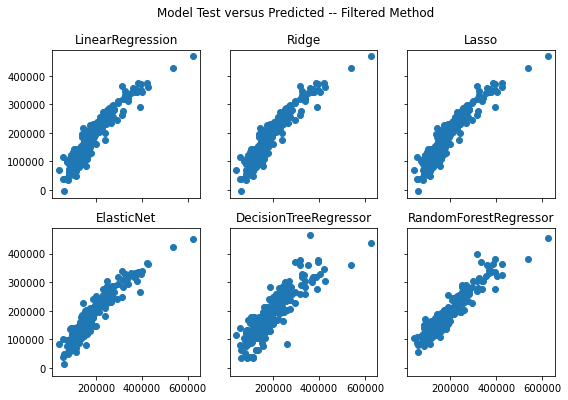

In [160]:
#plot charts to see predicted price and SalePrice differences
fig, axs=plt.subplots(2,3, figsize=(9,6), sharex=True, sharey=True)
axs[0,0].scatter(y_test, dict_results[0]["y_predicted"])
axs[0,0].set_title(model_name[0])
axs[0,1].scatter(y_test, dict_results[1]["y_predicted"])
axs[0,1].set_title(model_name[1])
axs[0,2].scatter(y_test, dict_results[2]["y_predicted"])
axs[0,2].set_title(model_name[2])
axs[1,0].scatter(y_test, dict_results[3]["y_predicted"])
axs[1,0].set_title(model_name[3])
axs[1,1].scatter(y_test, dict_results[4]["y_predicted"])
axs[1,1].set_title(model_name[4])
axs[1,2].scatter(y_test, dict_results[5]["y_predicted"])
axs[1,2].set_title(model_name[5])

fig.suptitle("Model Test versus Predicted -- Filtered Method",fontsize=12)

In [161]:
stats=pd.DataFrame(dict_results).iloc[0:2,]
stats.columns=(model_name)
stats

,LinearRegression,Ridge,Lasso,ElasticNet,DecisionTreeRegressor,RandomForestRegressor
model,LinearRegression(),Ridge(alpha=1.5),"Lasso(alpha=1, max_iter=5000)","ElasticNet(alpha=2.0, max_iter=300000)",DecisionTreeRegressor(max_depth=10),"(DecisionTreeRegressor(max_depth=10, max_featu..."
RMSE,28525.958087,28505.823211,28523.392626,28522.167863,39385.391106,28520.027106


In [162]:
# check the observed largest prediction errors (need more work)

# regressor = LinearRegressor()
# regressor.fit(X_train, y_train)

# y_predict_test = regressor.predict(X_test)
# df_decile = y_test.reset_index().merge(pd.DataFrame(y_predict_test, columns=["SalePricePredicted"]),
#                                        how="inner", left_index=True, right_index=True).set_index("index")
# # Calculate diff between predicted and actual for test dataset
# df_decile['diff'] = (df_decile.SalePrice-df_decile.SalePricePredicted)
# df_decile['diff_pct'] = (df_decile.SalePricePredicted/df_decile.SalePrice)-1
# df_decile = df_decile.reset_index().merge(X_train, how="inner", left_index=True,
#                                           right_index=True).set_index("index")
# pd.set_option('display.max_rows',
#               df.shape[0]+1), df_decile.sort_values(by='diff_pct').T

### 2. Wrapper method



The Wrapper method is a recursive feature elemination process to identify features importance. Here we implement it with sklearn's built in RFE function.

In [163]:
#reset the data to all features
df_fs_w = data_loader.df
X_train_fs_w, X_test_fs_w, y_train_fs_w, y_test_fs_w = data_loader.get_raw_split_fs()


In [164]:
#Split data and fill NA of 3 int/float columns

X_train = data_loader.data_prep(X_train_fs_w)
y_train = y_train_fs_w
X_test = data_loader.data_prep(X_test_fs_w)
y_test = y_test_fs_w


In [165]:
#implement the wrapper process 
def rfe_fs(regressor, threshold=35):
    ''' Select the most important 35 features based on the model
         and use it as X_train & X_test'''
    selector = RFE(regressor, n_features_to_select=threshold, step=1)
    if regressor.__dict__.get("base_estimator")!=None:
        if str(regressor.__dict__.get("base_estimator"))=="DecisionTreeRegressor()":
            selector = selector.fit(X_train, np.ravel(np.array(y_train)))
    else: selector = selector.fit(X_train, y_train)
    
    selector_ind = selector.get_support()
    X_train_rfe = X_train.iloc[:, selector_ind]
    X_test_rfe = X_test.iloc[:, selector_ind]
    rank=selector.ranking_

    return X_train_rfe, X_test_rfe,rank


In [166]:
def analyze_regression_rfe(regressor):
    """
    run regression on the selected top 35 features using RFE wrapper method
    calculate RMSE
    plot the predicted vs. actual SalePrice
    """

    X_train_rfe, X_test_rfe,rank = rfe_fs(regressor)

    if regressor.__dict__.get("base_estimator")!=None:
        if str(regressor.__dict__.get("base_estimator"))=="DecisionTreeRegressor()":
            regressor.fit(X_train_rfe,np.ravel(np.array(y_train)))
    else: regressor.fit(X_train_rfe, y_train)

    RMSE=mean_squared_error(y_test, regressor.predict(X_test_rfe),squared=False)
    #plt.scatter(y_test, regressor.predict(X_test_rfe))

    #print("For {model} the RMSE is {RMSE}".format(model=regressor,RMSE=RMSE))
    return X_train_rfe.columns, rank, regressor, RMSE, regressor.predict(X_test_rfe)

In [167]:
#run regressor and put features select, RMSE and predicted value into a dictionary
dict_rfe_results={}
k=0
for regressor in regressor_list:
    columns_used, rank, model_used, RMSE_result,y_predicted=analyze_regression_rfe(regressor)
    dict_rfe_results[k]={"columns_used":list(columns_used), "rank":rank,"model":model_used,"RMSE":RMSE_result,"y_predicted":y_predicted}
    k+=1

Text(0.5, 0.98, 'Model Test versus Predicted -- Wrapper Method')

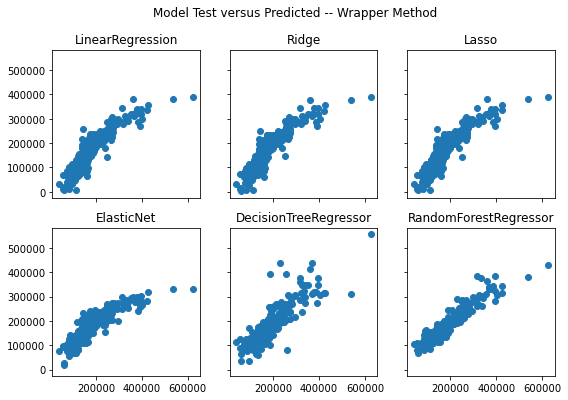

In [168]:
#plot the predict price vs. Sale price
fig, axs=plt.subplots(2,3, figsize=(9,6), sharex=True, sharey=True)
axs[0,0].scatter(y_test, dict_rfe_results[0]["y_predicted"])
axs[0,0].set_title(model_name[0])
axs[0,1].scatter(y_test, dict_rfe_results[1]["y_predicted"])
axs[0,1].set_title(model_name[1])
axs[0,2].scatter(y_test, dict_rfe_results[2]["y_predicted"])
axs[0,2].set_title(model_name[2])
axs[1,0].scatter(y_test, dict_rfe_results[3]["y_predicted"])
axs[1,0].set_title(model_name[3])
axs[1,1].scatter(y_test, dict_rfe_results[4]["y_predicted"])
axs[1,1].set_title(model_name[4])
axs[1,2].scatter(y_test, dict_rfe_results[5]["y_predicted"])
axs[1,2].set_title(model_name[5])

fig.suptitle("Model Test versus Predicted -- Wrapper Method",fontsize=12)

In [169]:
# show the feature selected by different models
pd.options.display.max_rows=80

pd.DataFrame.from_dict(dict(zip(dict_rfe_results[0]["columns_used"],dict_rfe_results[0]["rank"])),orient='index',columns=[model_name[0]+"_Rank"])

b=pd.merge(pd.Series(X_train.columns, name="original_columns"),pd.Series(features_selected,name="feature"),how="left",left_on="original_columns",right_on="feature")
for key in dict_rfe_results:
    b=pd.merge(b,
    pd.DataFrame.from_dict(dict(zip(dict_rfe_results[key]["columns_used"],dict_rfe_results[key]["rank"])),orient='index',columns=[model_name[key]+"_Rank"]),
    how="left",left_on="original_columns",right_index=True)

b.columns=["Original_Features"]+ ["FS-Filtered Method"] +['FS '+i+' - Wrapper Method'for i in model_name]
b

,Original_Features,FS-Filtered Method,FS LinearRegression - Wrapper Method,FS Ridge - Wrapper Method,FS Lasso - Wrapper Method,FS ElasticNet - Wrapper Method,FS DecisionTreeRegressor - Wrapper Method,FS RandomForestRegressor - Wrapper Method
0,MSSubClass,MSSubClass,NaN,NaN,NaN,NaN,NaN,1.0
1,MSZoning,NaN,16.0,16.0,23.0,8.0,38.0,NaN
2,LotFrontage,LotFrontage,NaN,NaN,NaN,NaN,1.0,9.0
3,LotArea,LotArea,NaN,NaN,NaN,NaN,1.0,1.0
4,Street,NaN,1.0,1.0,1.0,NaN,NaN,NaN
5,Alley,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,LotShape,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LandContour,NaN,NaN,NaN,NaN,1.0,NaN,NaN
8,Utilities,NaN,21.0,27.0,25.0,NaN,NaN,NaN
9,LotConfig,NaN,45.0,45.0,45.0,17.0,NaN,NaN


In [170]:
#run models with selected features and have a look at the RMSE
stats=pd.DataFrame(dict_rfe_results).iloc[2:4,]
stats.columns=(model_name)
stats

,LinearRegression,Ridge,Lasso,ElasticNet,DecisionTreeRegressor,RandomForestRegressor
model,LinearRegression(),Ridge(alpha=1.5),"Lasso(alpha=1, max_iter=5000)","ElasticNet(alpha=2.0, max_iter=300000)",DecisionTreeRegressor(max_depth=10),"(DecisionTreeRegressor(max_depth=10, max_featu..."
RMSE,37979.672021,38119.12609,37970.088546,41168.278819,40760.20592,29325.688691


The wrapper method with a threshold of 35 did not really provide an improvement in terms of minimize RMSE v.s. the base model. However, it provides insights to possible important features to include. The possible reasons for this are possibly the collinearity between a lot of variables.